# 1. Autoencoder

(1) Extract latent vectors & Reconstruct image w/ Autoencoder (AE)

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [2]:
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [3]:
trainset = datasets.FashionMNIST( # FashionMNIST 데이터
    root      = './.data/',
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)

100%|██████████| 26421880/26421880 [00:01<00:00, 14420055.12it/s]


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 266135.70it/s]


Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5053394.37it/s]


Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4283332.08it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [4]:
class Autoencoder(nn.Module): # Autoencoder 정의
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder (input: 28*28 image -> 3 as a latent vector)
        self.encoder = nn.Sequential( # 입력받은 이미지를 통해 latent vector를 만드는 encoder를 구축하는 코드이다.
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),
        )
        # Decoder (from latent vector (size: 3) -> decode it to 28*28 size image)
        self.decoder = nn.Sequential( # latent vector를 이용하여 이미지를 재구성하는 decoder를 구축하는 코드이다.
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x): # encoder : input, decoder : encoded vector
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [5]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005) # optimizer
criterion = nn.MSELoss() # MSE 사용

In [6]:
view_data = trainset.data[:5].view(-1, 28*28) #복원이 어떻게 되는지 관찰하기 위해 5개의 이미지를 가져와 바로 넣어보기
view_data = view_data.type(torch.FloatTensor)/255. #픽셀의 색상값 조절

In [7]:
def train(autoencoder, train_loader): # 학습을 위한 함수
    autoencoder.train() # 학습용으로 전환하는 코드
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE) # x(입력)와 y(대상 레이블)모두 원본이미지(x)인 것을 주의
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y) # 실제값과 디코딩하여 얻은 값을 비교하여 오차값을 계산
        optimizer.zero_grad() # 기울기 초기화
        loss.backward() # 기울기 계산
        optimizer.step() # 가중치 업데이트

[Epoch 1]


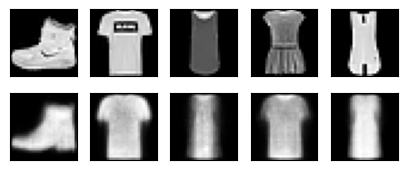

[Epoch 2]


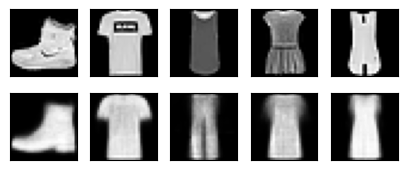

[Epoch 3]


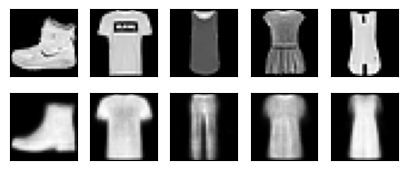

[Epoch 4]


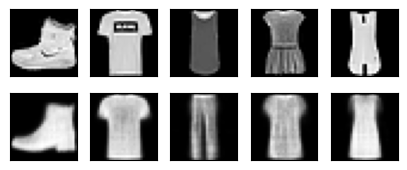

[Epoch 5]


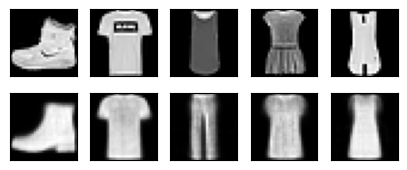

[Epoch 6]


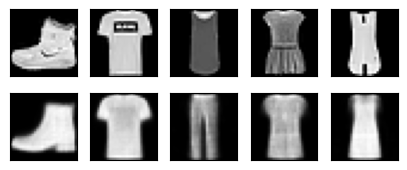

[Epoch 7]


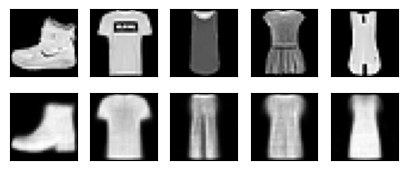

[Epoch 8]


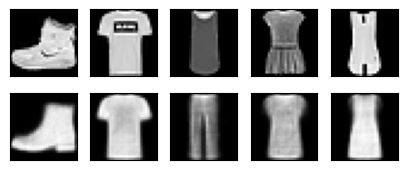

[Epoch 9]


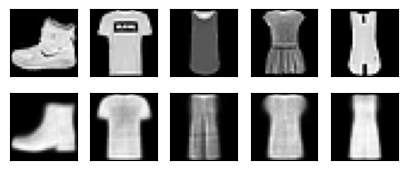

[Epoch 10]


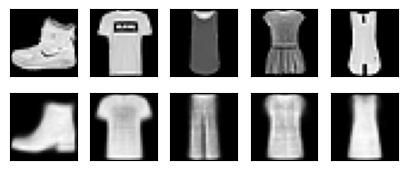

In [8]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    # 원본과 디코딩 결과 비교해보기
    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28, 28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

(2) Image Denoising w/ AE

In [9]:
def add_noise(img): # 입력 이미지에 잡음(noise) 더하기
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

In [10]:
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        noisy_x = add_noise(x)
        noisy_x = noisy_x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)

        label = label.to(DEVICE)
        encoded, decoded = autoencoder(noisy_x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item() # 평균 오차 관찰
    return avg_loss / len(train_loader)

In [11]:
for epoch in range(1, EPOCH+1):
    loss = train(autoencoder, train_loader)
    print("[Epoch {}] loss:{}".format(epoch, loss))

[Epoch 1] loss:0.02360227236996836
[Epoch 2] loss:0.023227778307076837
[Epoch 3] loss:0.023245277095721092
[Epoch 4] loss:0.023128979861227944
[Epoch 5] loss:0.02301335745830653
[Epoch 6] loss:0.023082654526048123
[Epoch 7] loss:0.02284008220259124
[Epoch 8] loss:0.022859430585954108
[Epoch 9] loss:0.022849273436994694
[Epoch 10] loss:0.022886125464190932


In [12]:
testset = datasets.FashionMNIST(
    root      = './.data/',
    train     = False, # test dataset
    download  = True,
    transform = transforms.ToTensor()
)

sample_data = testset.data[0].view(-1, 28*28) #1차원 행렬로 변환
sample_data = sample_data.type(torch.FloatTensor)/255.

# 이미지를 add_noise로 오염시킨 후, 모델에 통과
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

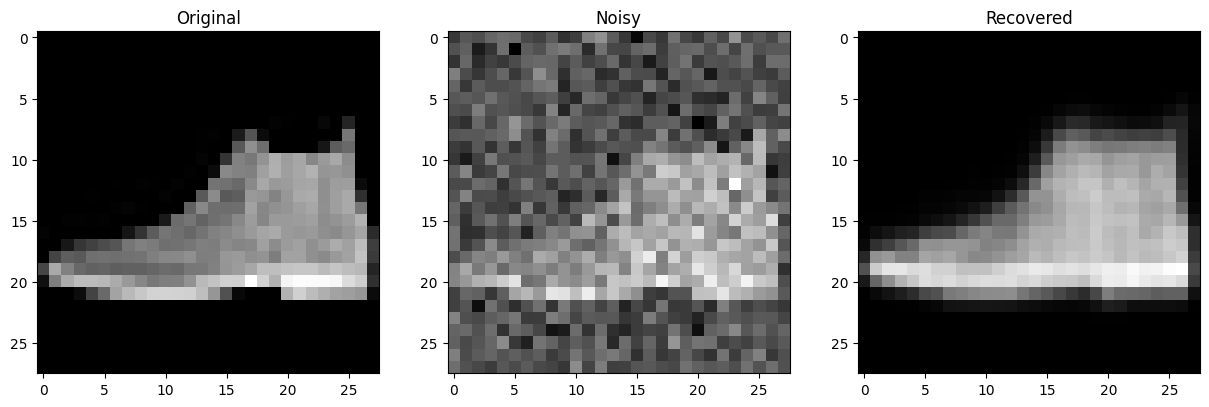

In [13]:
f, a = plt.subplots(1, 3, figsize=(15, 15))

original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

# original image
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

# original image w/ noise
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# recoveredimage
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()

Question 1. Explain the code of the '1. Autoencoder' section "briefly".

# 2. Principal Component Analysis [PCA]

Question 2. What is PCA in "mathematical" perspective? Google it and write your own answer.

PCA(Pricipal Component Analysis)는 가장 대표적인 차원 축소 기법중 하나이다.
여러 변수간에 존재하는 상관관계를 이용하여 이를 대표하는 주성분을 추출하여 차원을 축소한다.
직관적으로는 어떠한 데이터를 가장 잘 표현할 수 있는 벡터를 찾는 기법이다.
선형대수학 관점에서 PCA를 해석해보면, 입력 데이터를 공분산 행렬을 고유값 분해한 후 구한 고유벡터에 입력 데이터를 선형 변환하는 것이다.
이때, 고유벡터는 PCA의 주성분 벡터로서 입력 데이터의 분산이 가장 큰 방향을 나타낸다. 또한, 고유값을 고유벡터의 크기를 나타내며 동시에 입력 데이터의 분산을 나타낸다.
PCA는 다음과 같은 과정으로 진행된다.
1. 입력 데이터 세트의 공분산 행렬을 계산한다.
2. 공분산 행렬의 고유값과 고유벡터를 계산한다.
3. 고유값이 가장 큰 순으로 K개 만큼 고유벡터를 추출한다.
4. 고유값이 가장 큰 순으로 추출된 고유벡터를 이용하여 새롭게 입력 데이터를 변환한다.

In [14]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic')
mpl.rc('axes', unicode_minus=False)

sns.set(rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

In [16]:
from sklearn.datasets import load_iris

iris = load_iris()

columns = ['sepal_length','sepal_width','petal_length','petal_width']
iris_df = pd.DataFrame(data = iris.data, columns = columns)
iris_df["target"] = iris.target

iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


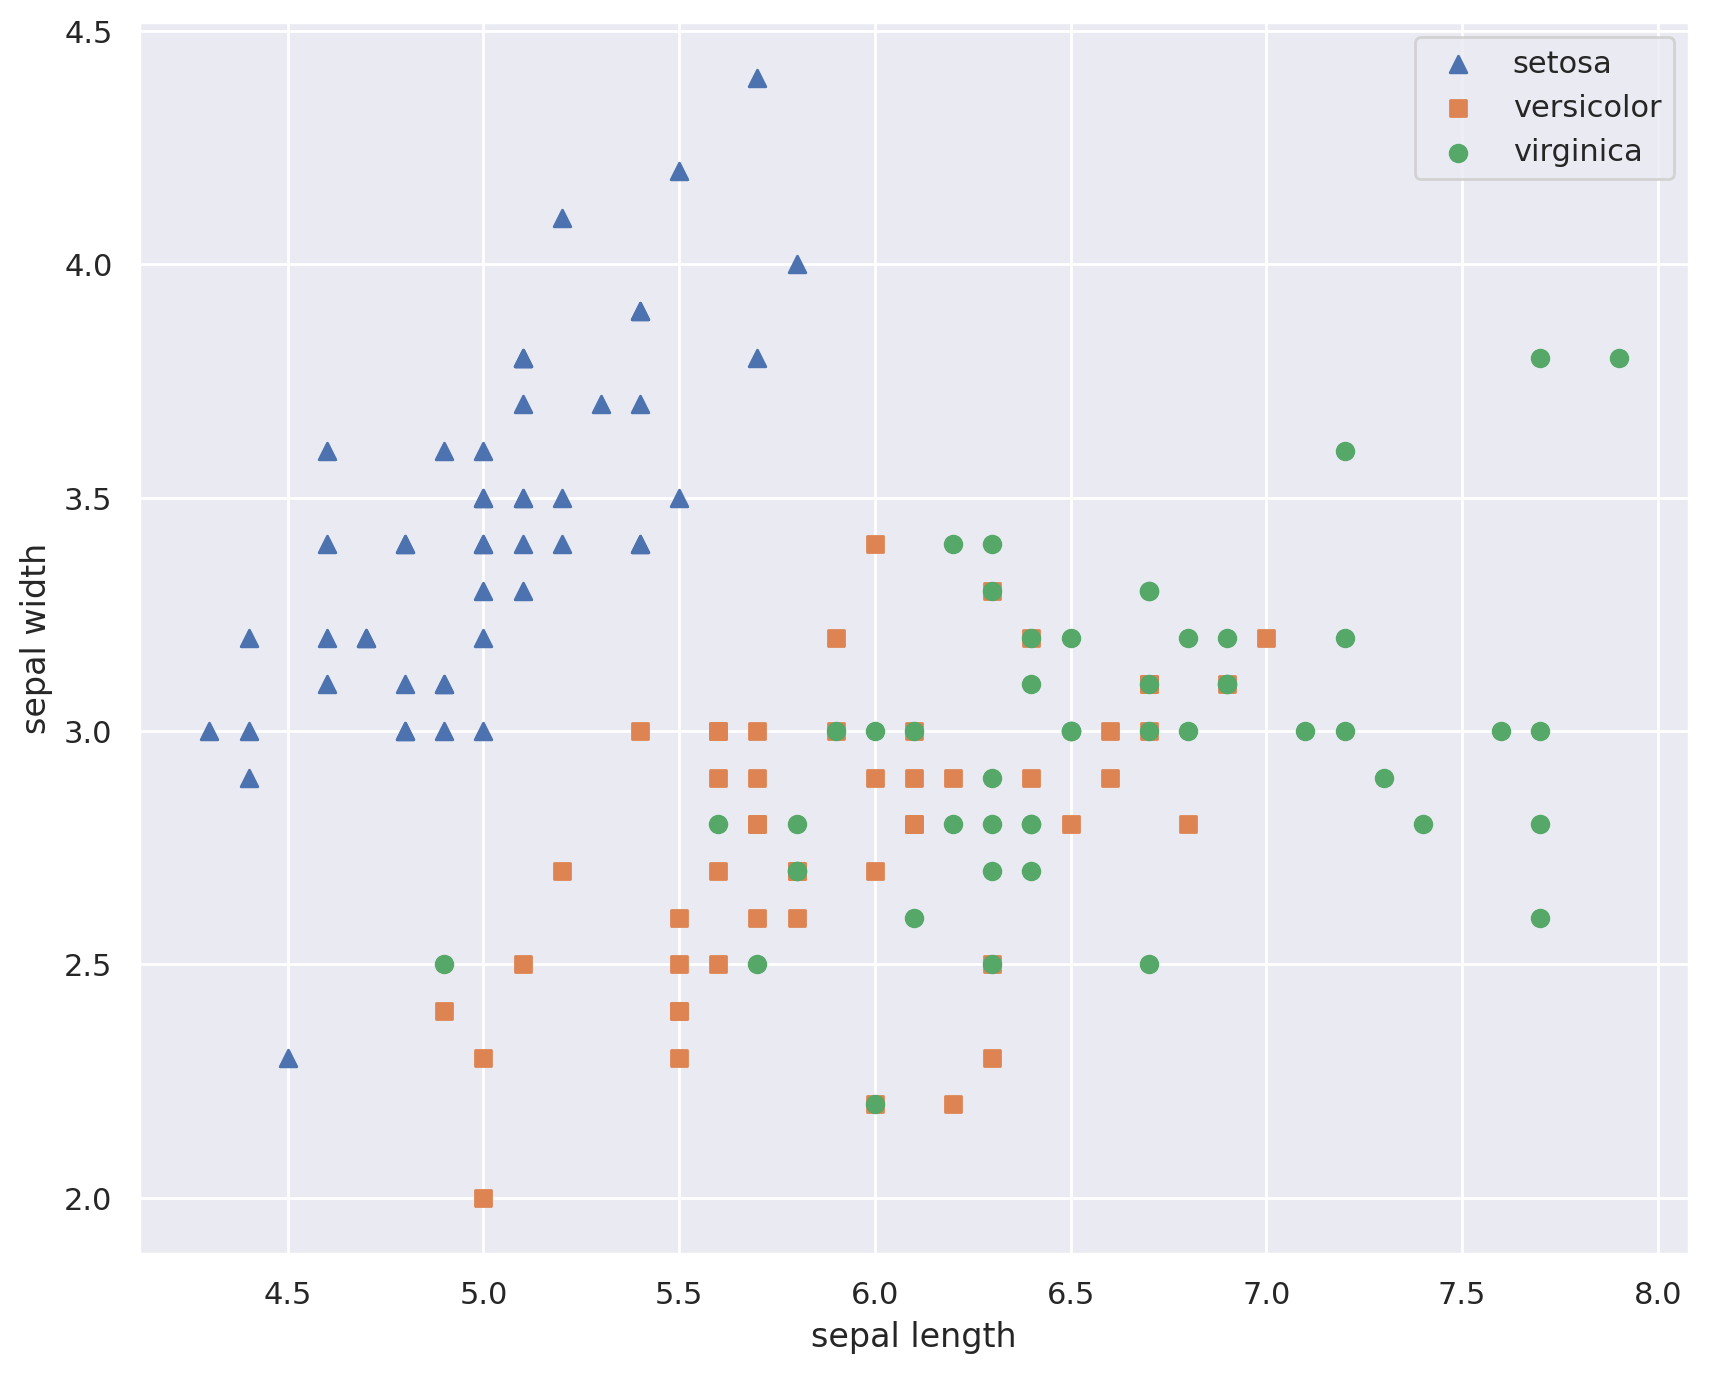

In [17]:
markers = ["^", "s", "o"]

# 0:setosa, 1:versicolor, 2:virginica
for i, marker in enumerate(markers):
    x_axis_data = iris_df[iris_df['target']==i]['sepal_length']
    y_axis_data = iris_df[iris_df['target']==i]['sepal_width']
    plt.scatter(x_axis_data, y_axis_data, marker=marker, label=iris.target_names[i])

plt.legend()
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.show()

In [18]:
from sklearn.preprocessing import StandardScaler

iris_f_scaled = StandardScaler().fit_transform(iris_df.iloc[:,:-1])

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2) # of principal components = 2

pca.fit(iris_f_scaled)
iris_pca = pca.transform(iris_f_scaled)

print(f"scaled: {iris_f_scaled.shape}")
print(f"pca: {iris_pca.shape}")

scaled: (150, 4)
pca: (150, 2)


In [20]:
pca_columns=['pca_component_1','pca_component_2']

iris_df_pca = pd.DataFrame(iris_pca, columns = pca_columns)
iris_df_pca['target'] = iris.target

iris_df_pca.head(3)

,pca_component_1,pca_component_2,target
0,-2.264703,0.480027,0
1,-2.080961,-0.674134,0
2,-2.364229,-0.341908,0


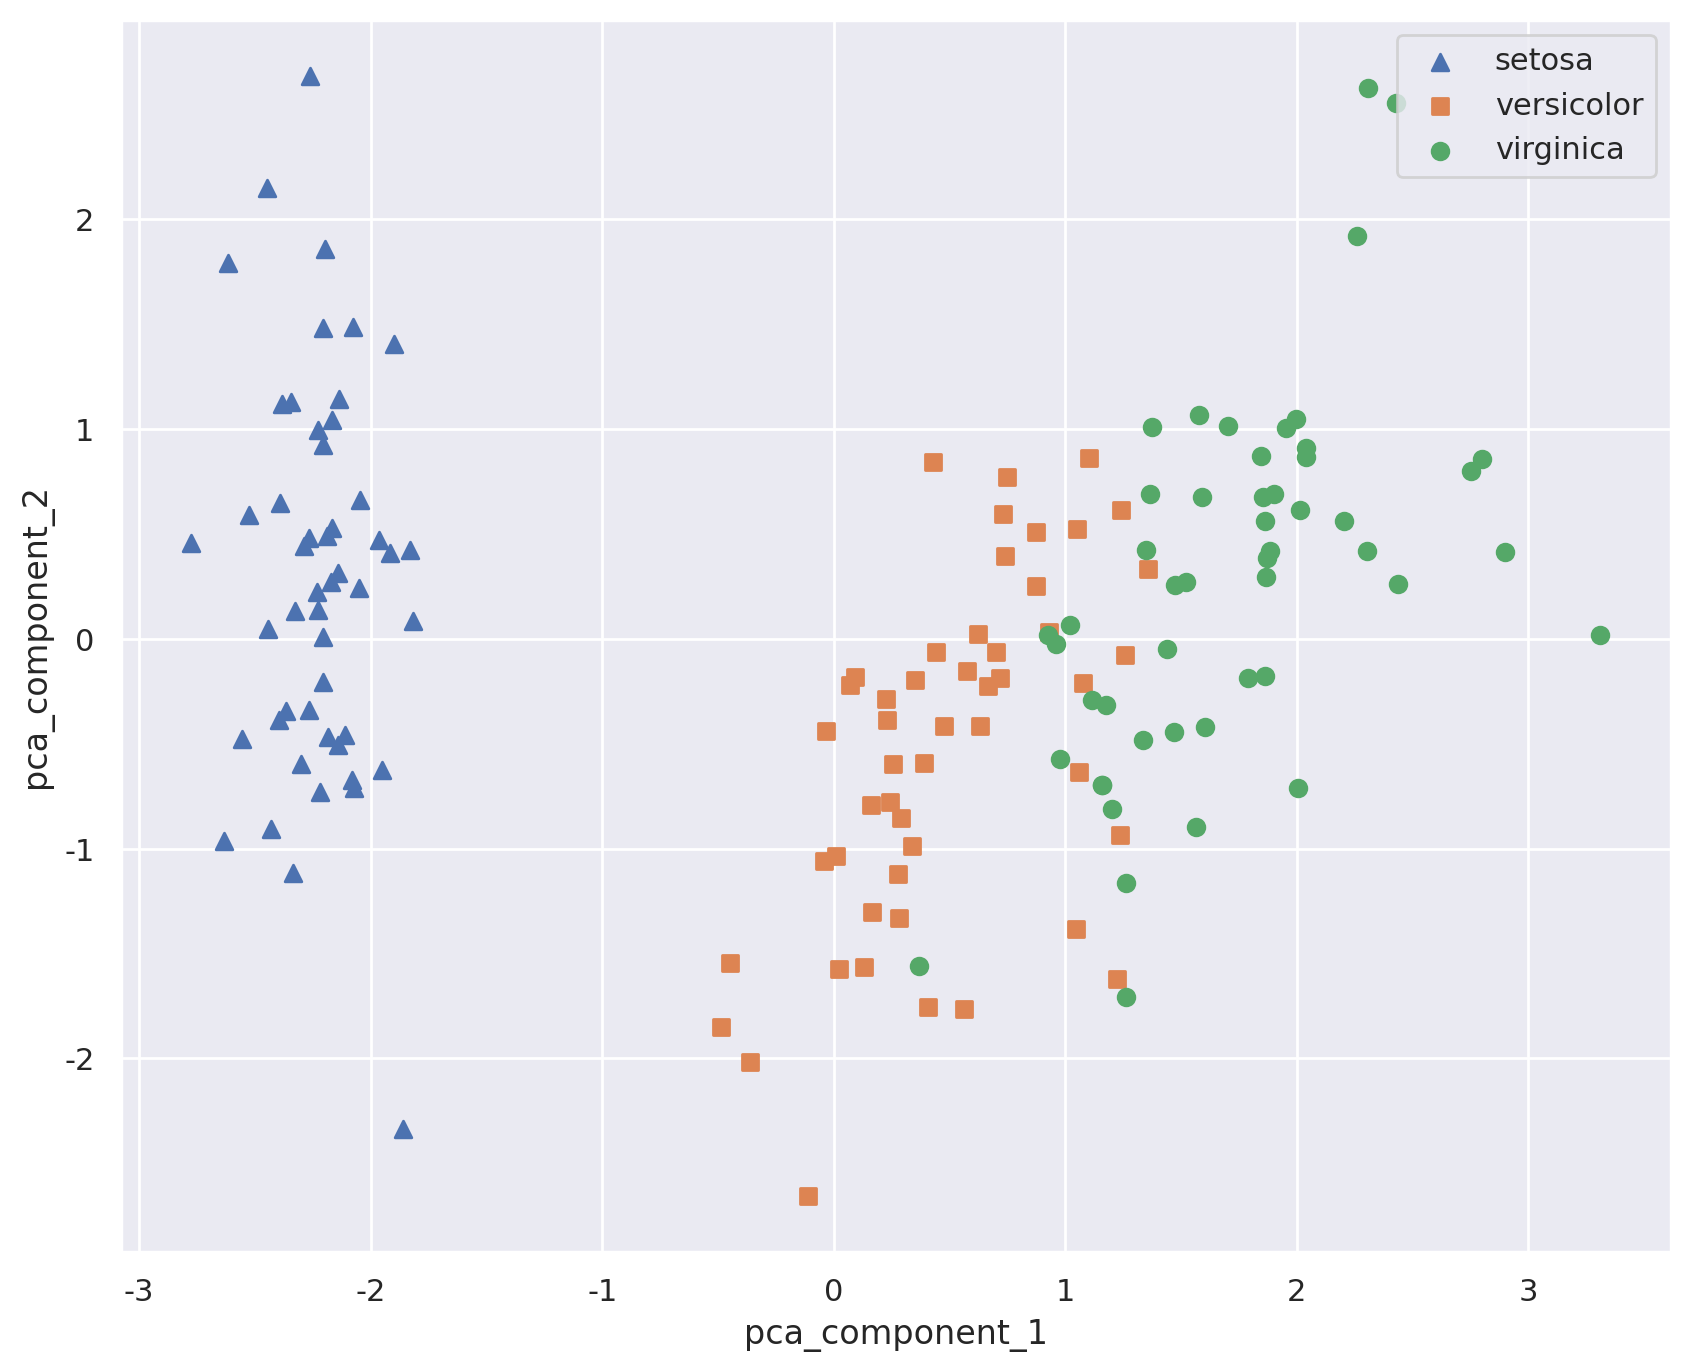

In [21]:
markers = ["^", "s", "o"]

# 0:setosa, 1:versicolor, 2:virginica
for i, marker in enumerate(markers):
    x_axis_data = iris_df_pca[iris_df_pca['target']==i]['pca_component_1']
    y_axis_data = iris_df_pca[iris_df_pca['target']==i]['pca_component_2']
    plt.scatter(x_axis_data, y_axis_data, marker=marker,label=iris.target_names[i])

plt.legend()
plt.xlabel('pca_component_1')
plt.ylabel('pca_component_2')
plt.show()

In [22]:
print(pca.explained_variance_ratio_) ## Although we implemented PCA, we can still explain majority of the data

[0.72962445 0.22850762]


Question 3.
Autoencoder reduces the dimension of the data w/ deep learning methods.
PCA does the same thing in mathematically linear way.
In this context, Autoencoder is a _ _ _ _ _ _ _ _ _ PCA.
Hint: n _ _ l _ _ _ _ _

=> non linear

# 3. Variational Autoencoder (VAE)

Question 4 (Optional).
Read the following document, run the whole code and write an explanation.

https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb

In [23]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [24]:
# Model Hyperparameters

dataset_path = '/content'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

Step 1. Load (or download) Dataset

In [25]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 37552623.58it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1145653.70it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10658772.74it/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10370456.60it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



Step 2. Define model: VAE

In [26]:
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var

In [27]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [28]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon
        z = mean + var*epsilon                          # reparameterization trick
        return z


    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)

        return x_hat, mean, log_var

In [29]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

Step 3. Define Loss function (reprod. loss) and optimizer

In [30]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

Step 4. Train Variational AutoEncoder (VAE)

In [31]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  172.8385380256156
	Epoch 2 complete! 	Average Loss:  127.84159292179675
	Epoch 3 complete! 	Average Loss:  117.43459129473602
	Epoch 4 complete! 	Average Loss:  113.43412665314587
	Epoch 5 complete! 	Average Loss:  110.36517309121975
	Epoch 6 complete! 	Average Loss:  108.45597560061039
	Epoch 7 complete! 	Average Loss:  107.18336954820535
	Epoch 8 complete! 	Average Loss:  106.1700276339472
	Epoch 9 complete! 	Average Loss:  105.39536162158285
	Epoch 10 complete! 	Average Loss:  104.78232413723393
	Epoch 11 complete! 	Average Loss:  104.24887410006261
	Epoch 12 complete! 	Average Loss:  103.7689619743844
	Epoch 13 complete! 	Average Loss:  103.37428205537876
	Epoch 14 complete! 	Average Loss:  103.02309346958472
	Epoch 15 complete! 	Average Loss:  102.70381010994888
	Epoch 16 complete! 	Average Loss:  102.42729678044137
	Epoch 17 complete! 	Average Loss:  102.17357716963168
	Epoch 18 complete! 	Average Loss:  101.96782140155467


Step 5. Generate images from test dataset

In [32]:
import matplotlib.pyplot as plt

In [33]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x)


        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [34]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

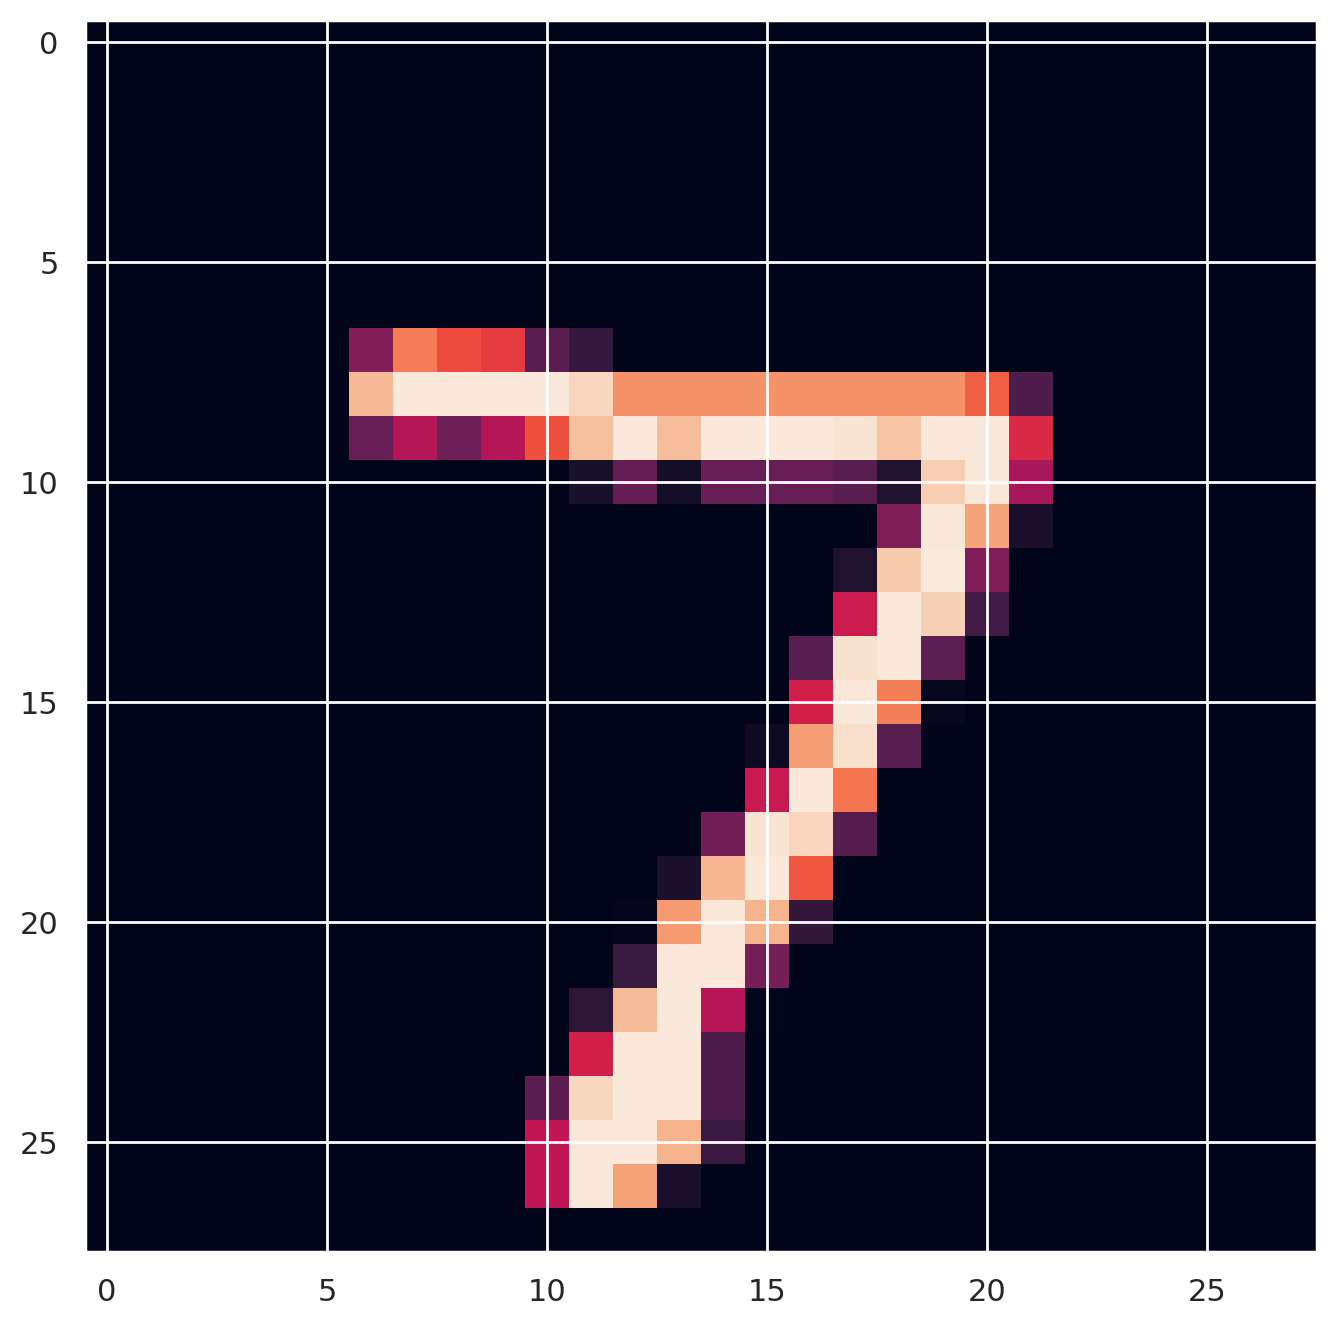

In [35]:
show_image(x, idx=0)

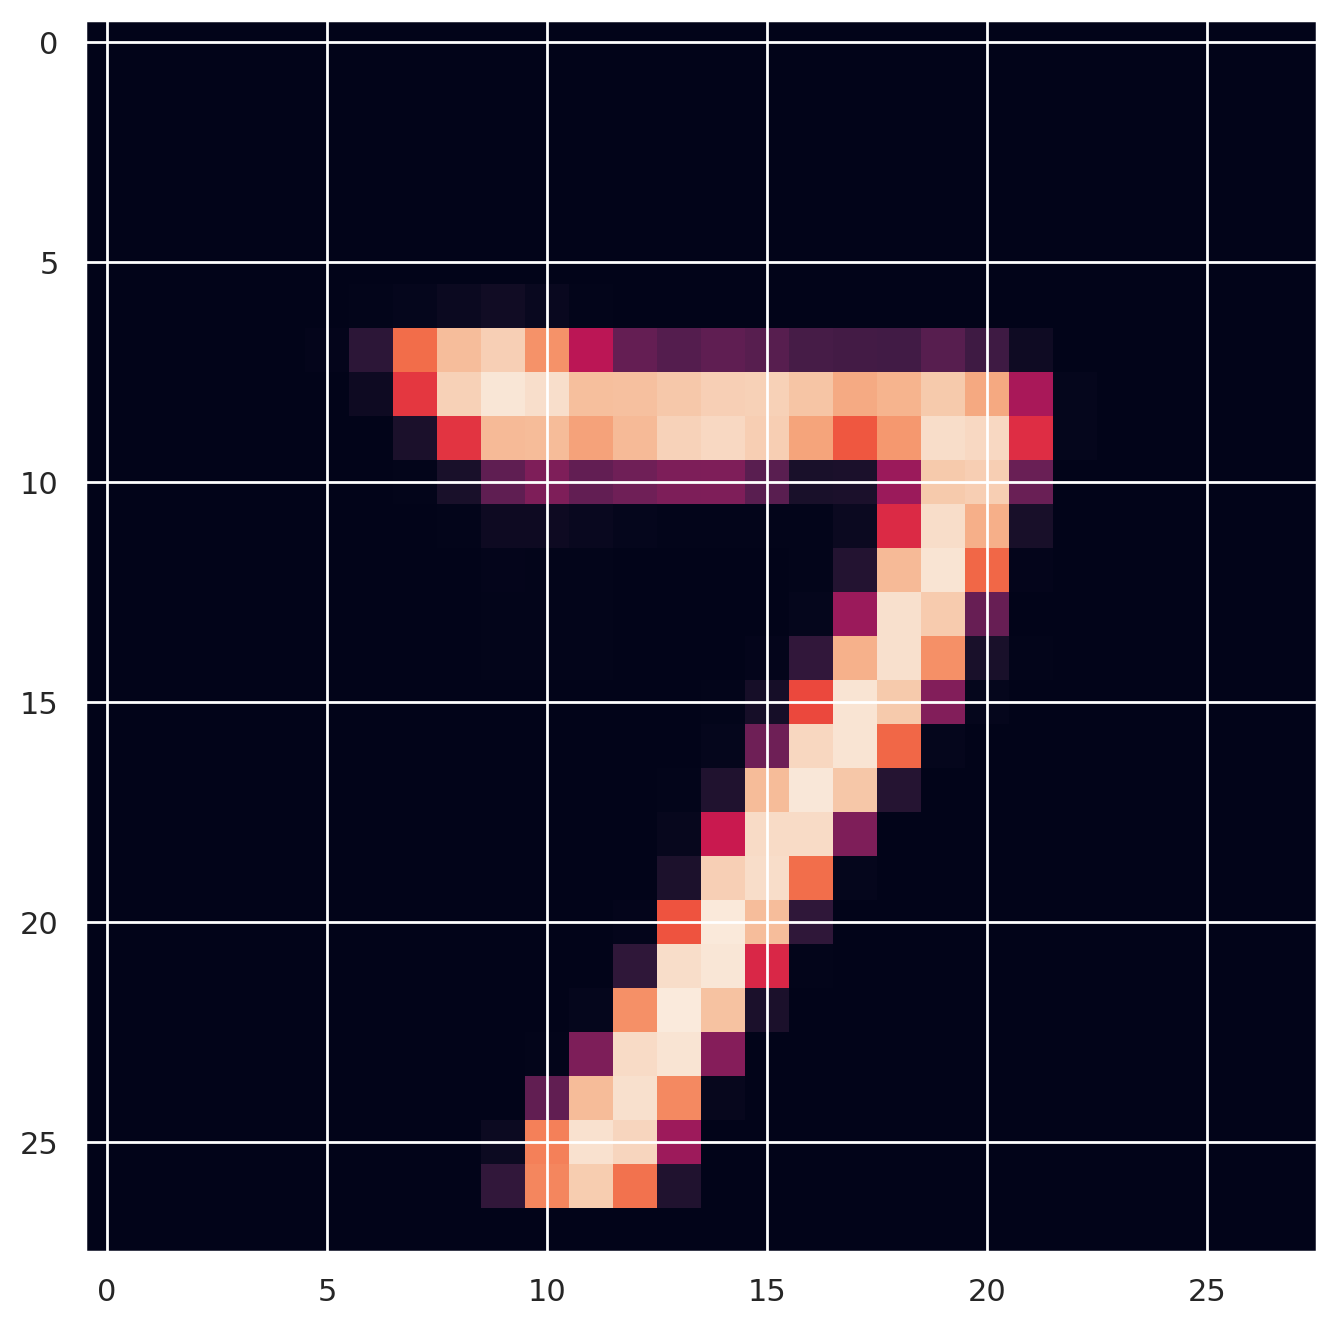

In [36]:
show_image(x_hat, idx=0)

Step 6. Generate image from noise vector

In [37]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [38]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

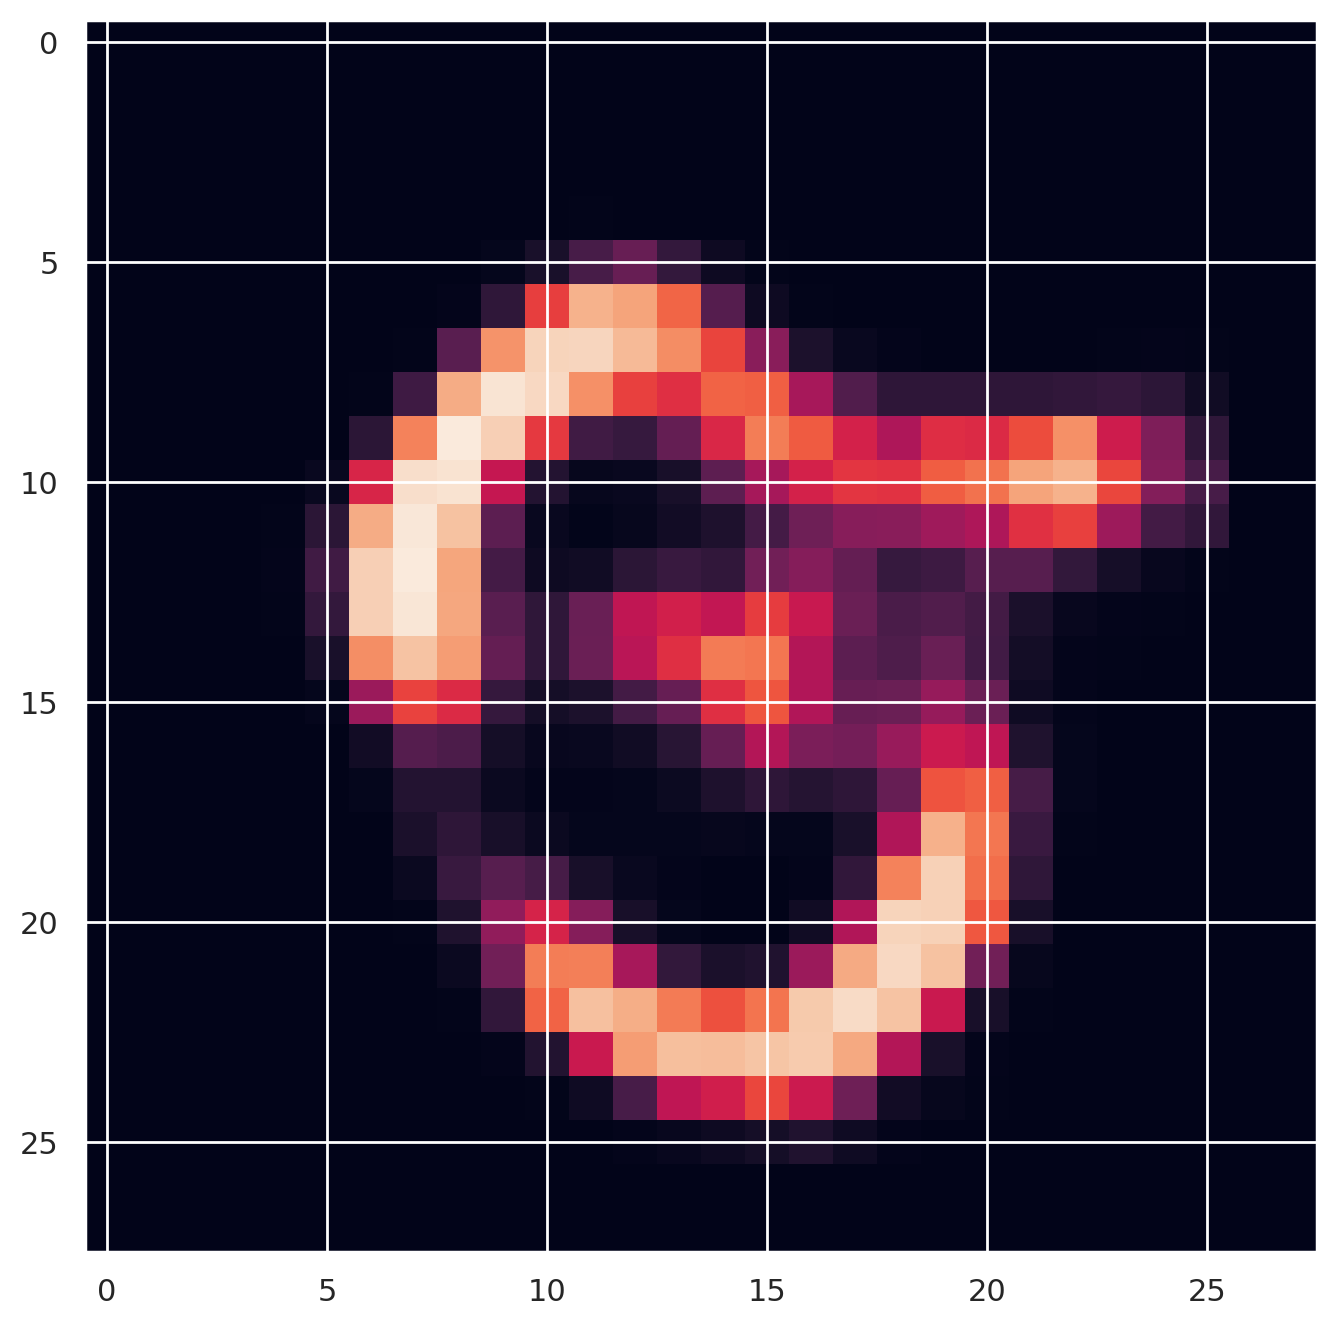

In [39]:
show_image(generated_images, idx=12)

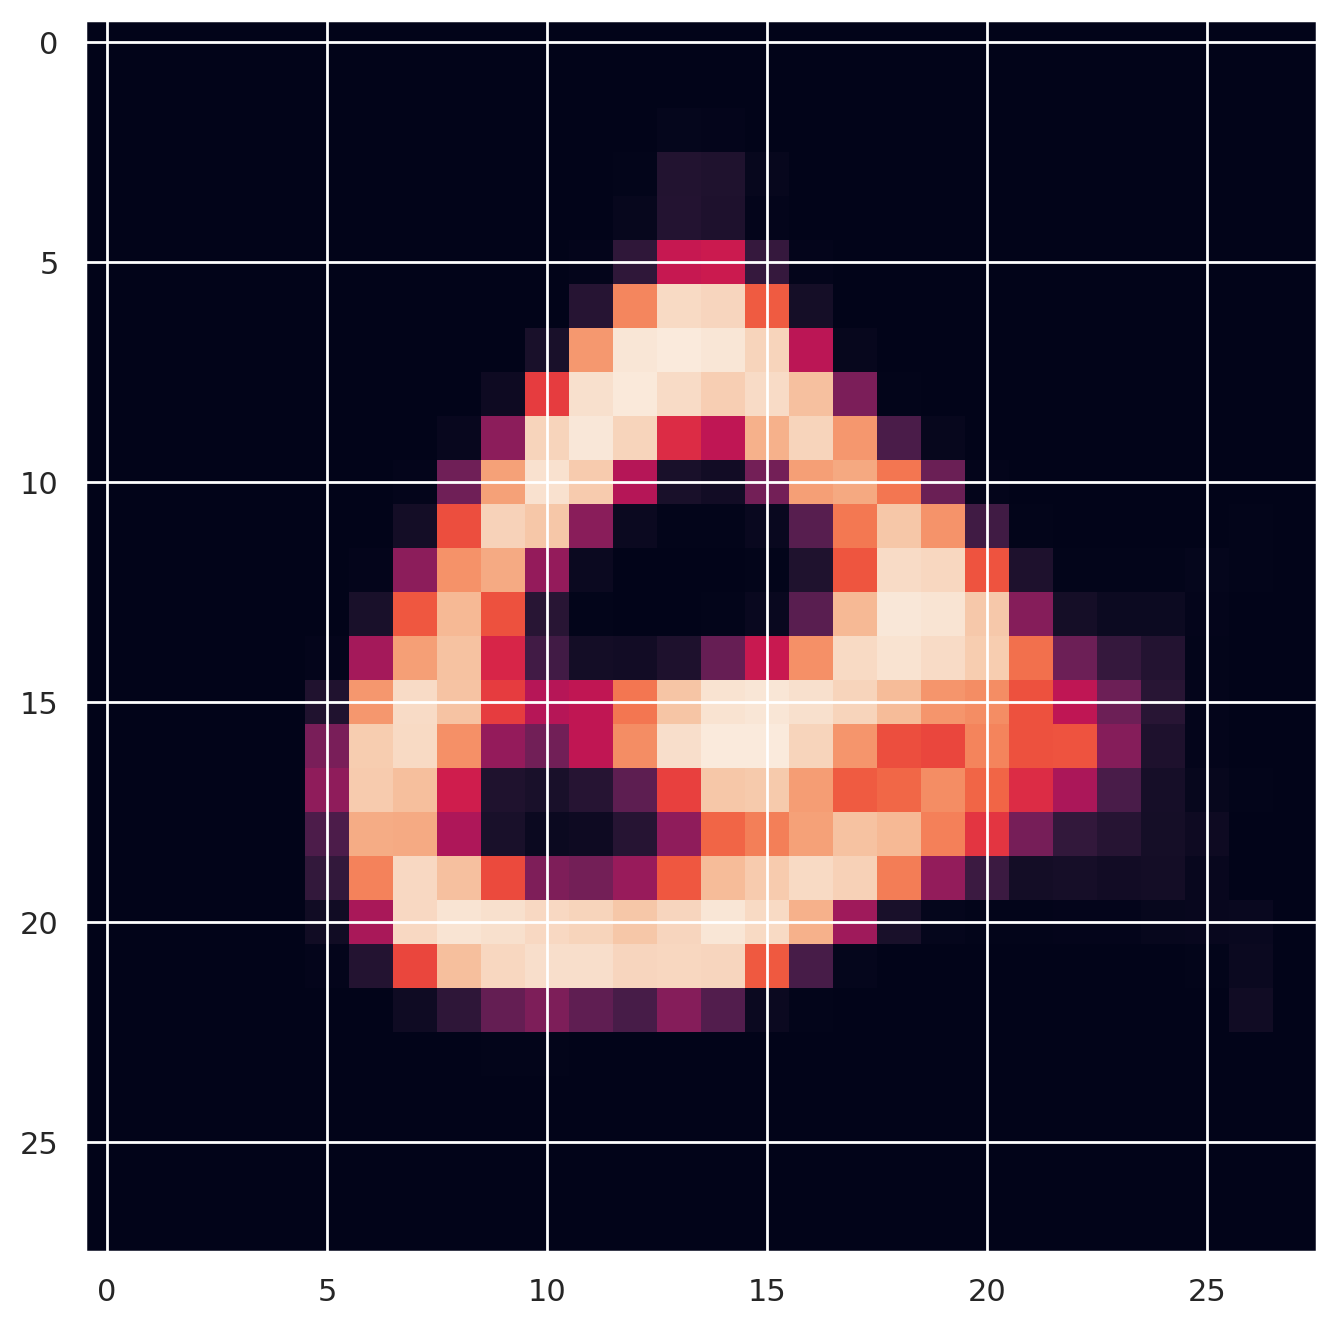

In [40]:
show_image(generated_images, idx=0)

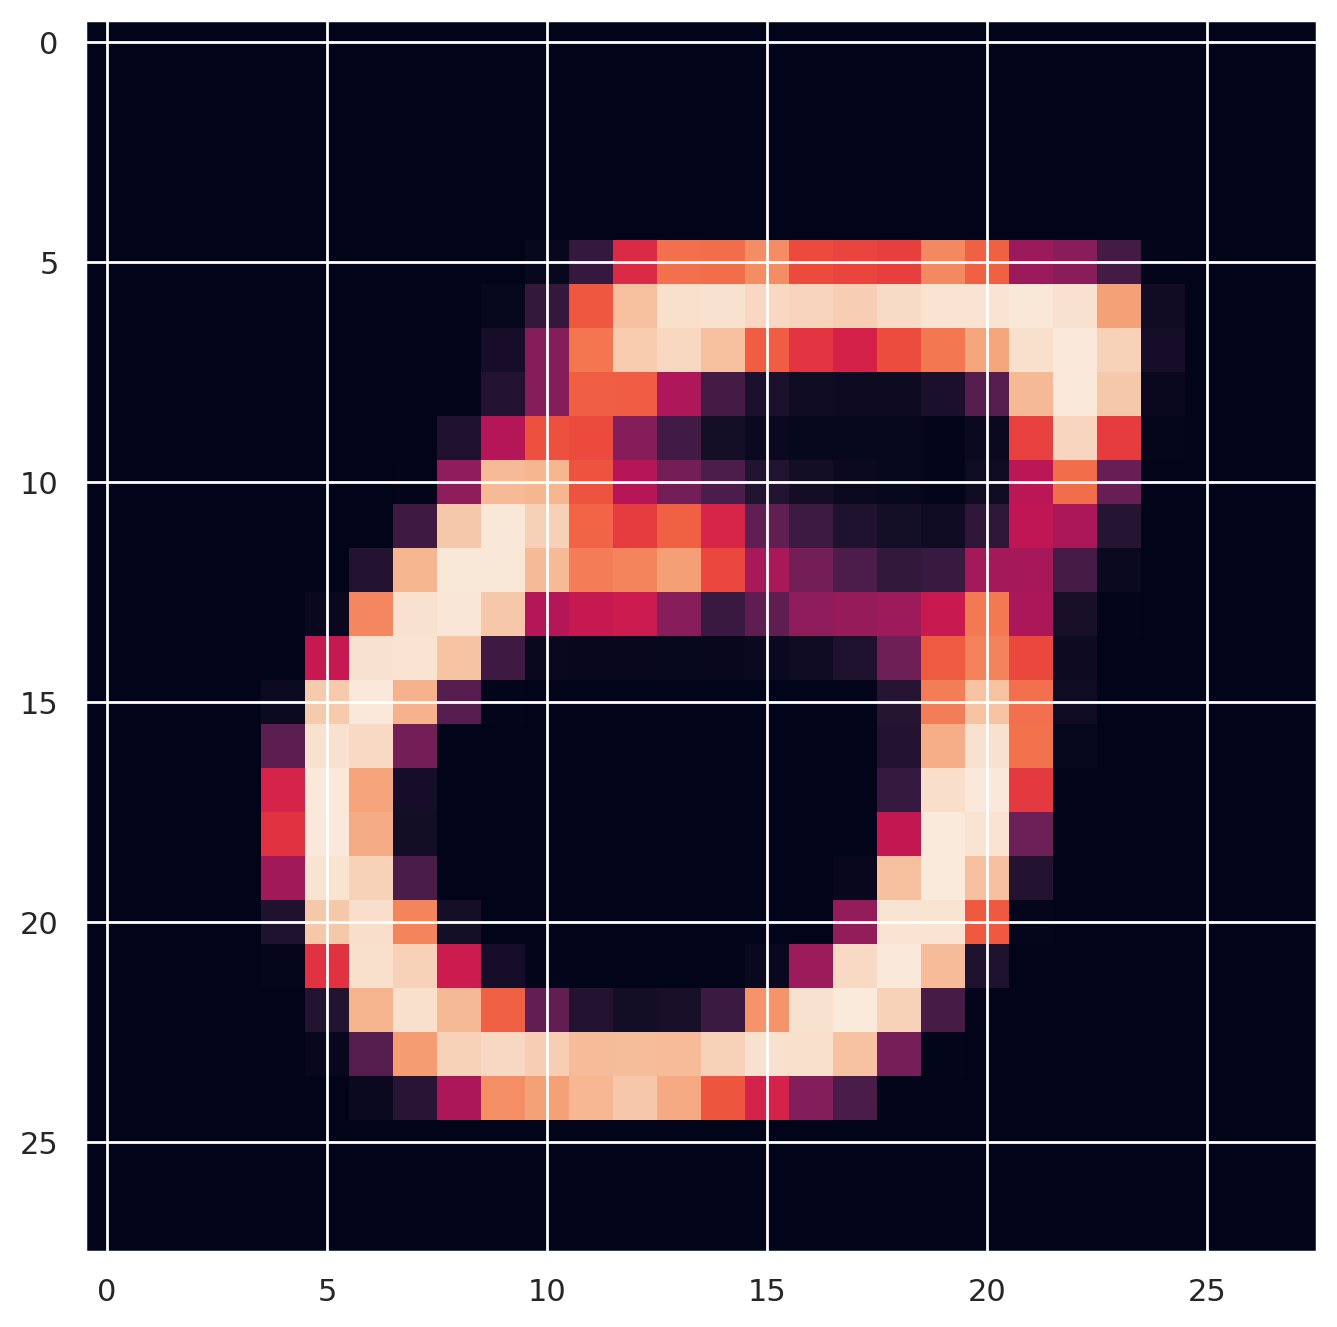

In [41]:
show_image(generated_images, idx=1)

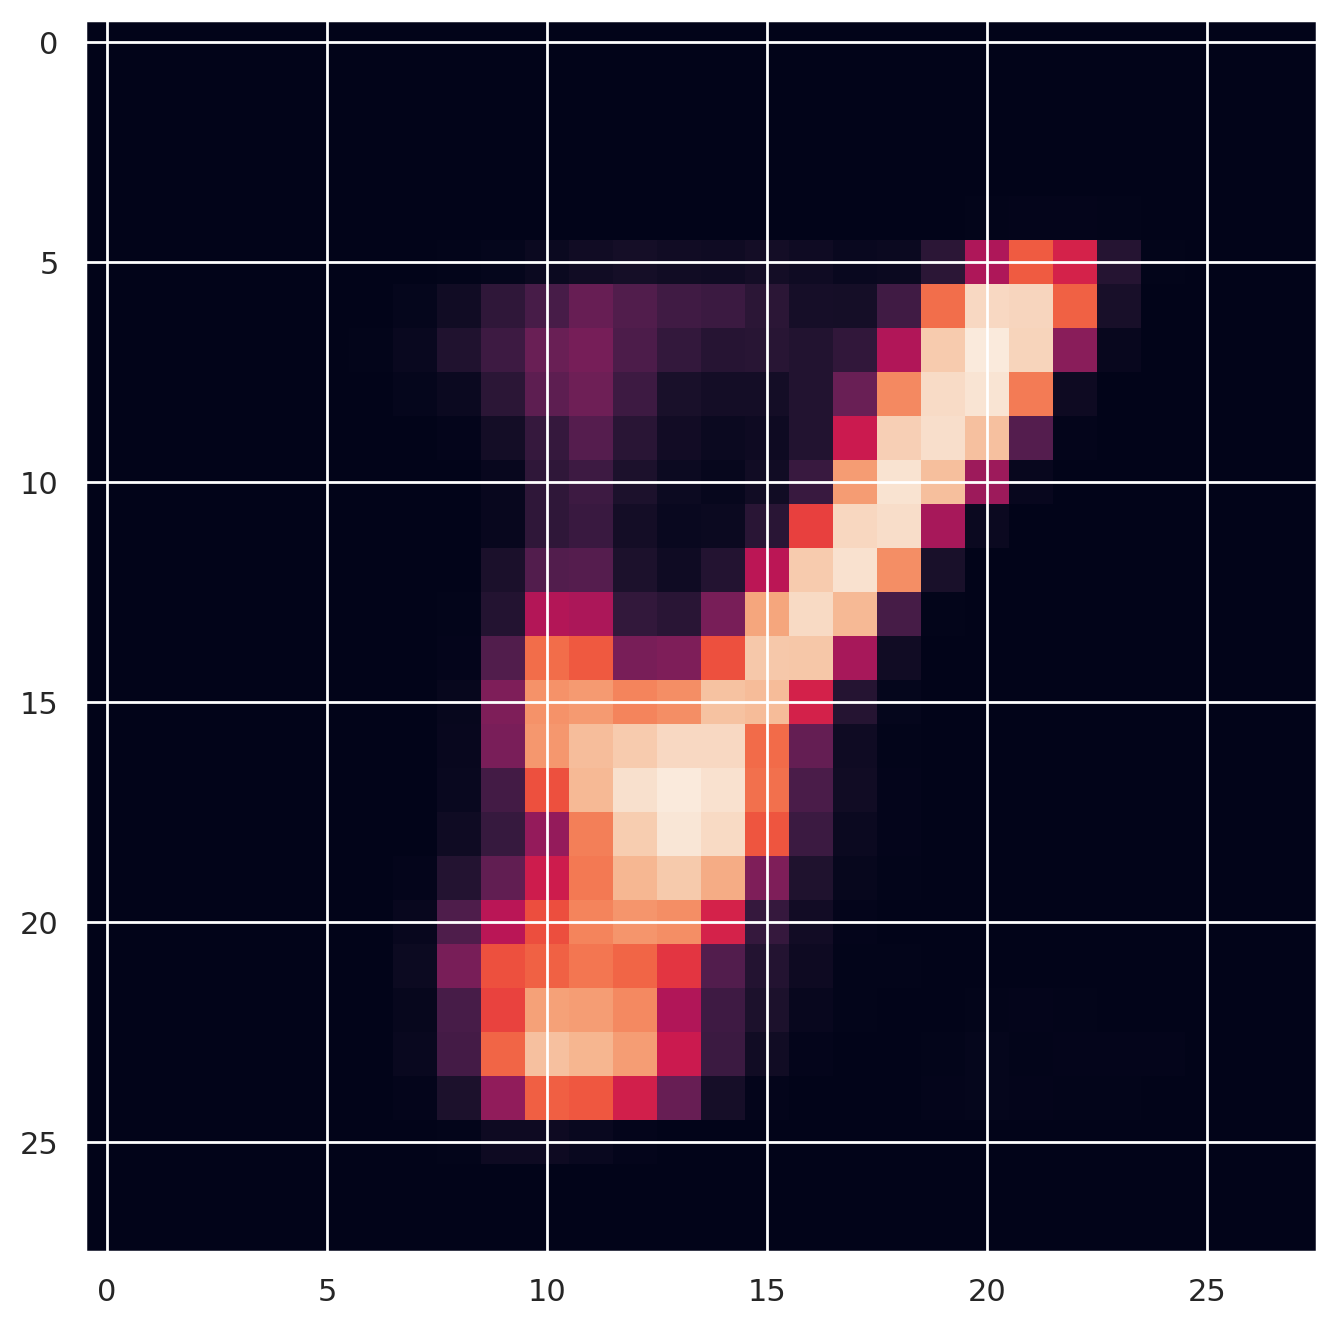

In [42]:
show_image(generated_images, idx=10)

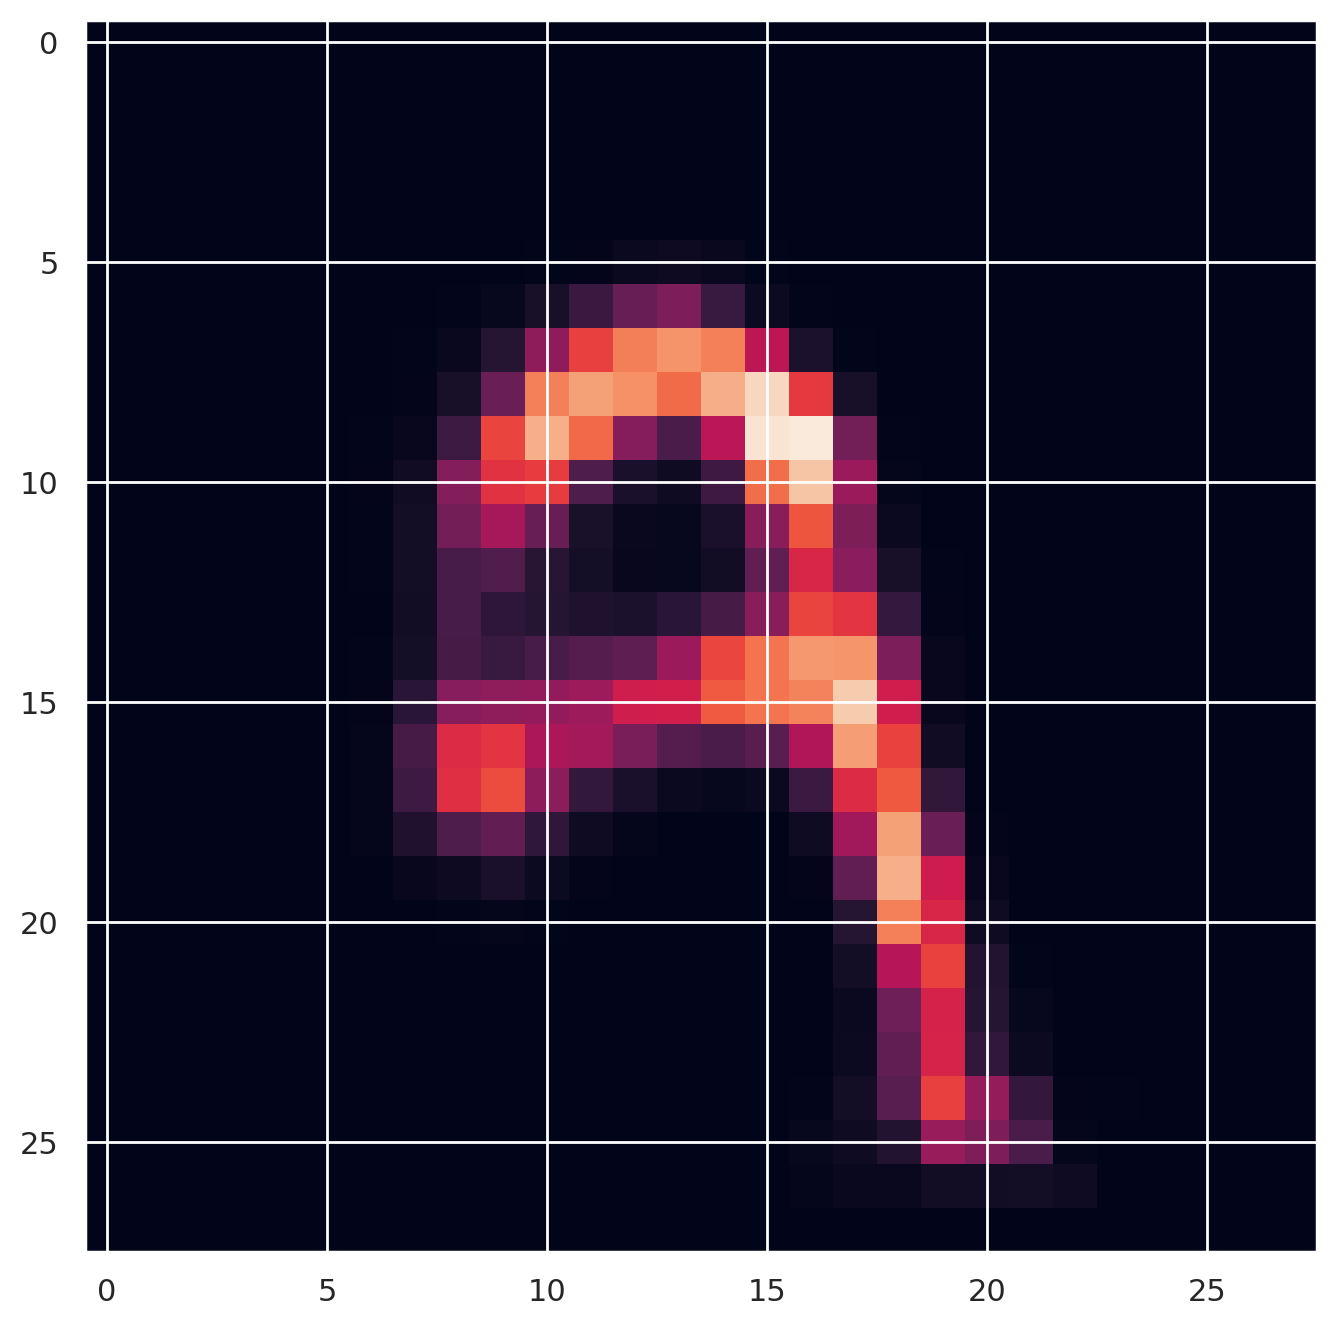

In [43]:
show_image(generated_images, idx=50)